In [563]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
import scipy.stats as stats
import random

In [933]:
dataset_name2 = '../recomb_ssc.hg38_upd'
ped_file2 = '../../DATA/ssc.hg38/ssc.ped'

dataset_name = '../recomb_ihart.ms2_upd'
ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'

In [934]:
with open('%s/upds.json' % dataset_name, 'r') as f:
    upds = json.load(f)
    x_upds = [x for x in upds if x['chrom'] == 'X' and (not x['is_hts'])]
    upds = [x for x in upds if x['chrom'] != 'X' and (not x['is_hts'])]
print(len(upds), len(x_upds))

with open('%s/upds.json' % dataset_name2, 'r') as f:
    upds2 = json.load(f)
    x_upds2 = [x for x in upds2 if x['chrom'] == 'X' and (not x['is_hts'])]
    upds2 = [x for x in upds2 if x['chrom'] != 'X' and (not x['is_hts'])]
print(len(upds2), len(x_upds2))





6613 2176
17422 3855


In [935]:
# remove upds in telomeres
telomeric_regions = []
with open('../data/centromere38.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        telomeric_regions.append((pieces[0][3:], int(pieces[1])-1000000, int(pieces[2])+1000000))
with open('../data/telomere38.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        telomeric_regions.append((pieces[0][3:], int(pieces[1])-1000000, int(pieces[2])+1000000))


In [936]:
is_telomere = np.zeros((len(upds),), dtype=bool)
is_telomere2 = np.zeros((len(upds2),), dtype=bool)
for i, upd in enumerate(upds):
    for tr in telomeric_regions:
        if (upd['chrom'] == tr[0]) and (min(upd['end_pos'], tr[2])-max(upd['start_pos'], tr[1]) > 0):
            is_telomere[i] = True
            
for i, upd in enumerate(upds2):
    for tr in telomeric_regions:
        if (upd['chrom'] == tr[0]) and (min(upd['end_pos'], tr[2])-max(upd['start_pos'], tr[1]) > 0):
            is_telomere2[i] = True
            
print(np.sum(is_telomere)/len(is_telomere), np.sum(is_telomere2)/len(is_telomere2))
            

0.38515046121276275 0.30696820112501433


In [937]:
child_to_upds = defaultdict(int)
child_to_upds_len = defaultdict(int)
for i, upd in enumerate(upds):
    #if not is_telomere[i]:
    child_to_upds[(upd['family'], upd['child'])] += 1
    child_to_upds_len[(upd['family'], upd['child'])] += upd['end_pos'] - upd['start_pos']
    
child_to_upds2 = defaultdict(int)
child_to_upds_len2 = defaultdict(int)
for i, upd in enumerate(upds2):
    #if not is_telomere2[i]:
    child_to_upds2[(upd['family'], upd['child'])] += 1
    child_to_upds_len2[(upd['family'], upd['child'])] += upd['end_pos'] - upd['start_pos']



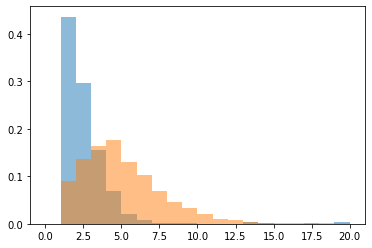

In [938]:
plt.hist(np.clip(list(child_to_upds.values()), None, 20), bins=np.arange(21), alpha=0.5, density=True)
plt.hist(np.clip(list(child_to_upds2.values()), None, 20), bins=np.arange(21), alpha=0.5, density=True)
plt.show()

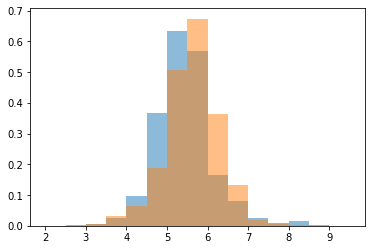

In [939]:
plt.hist(np.log10(list(child_to_upds_len.values())), bins=np.arange(2, 10, 0.5), alpha=0.5, density=True)
plt.hist(np.log10(list(child_to_upds_len2.values())), bins=np.arange(2, 10, 0.5), alpha=0.5, density=True)
plt.show()

In [940]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if 'ssc' in ped_file:
                child_id = child_id.replace('.', '_')
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex


print('ped loaded')
print('children', len(child_id_to_affected))


ped loaded
children 2635


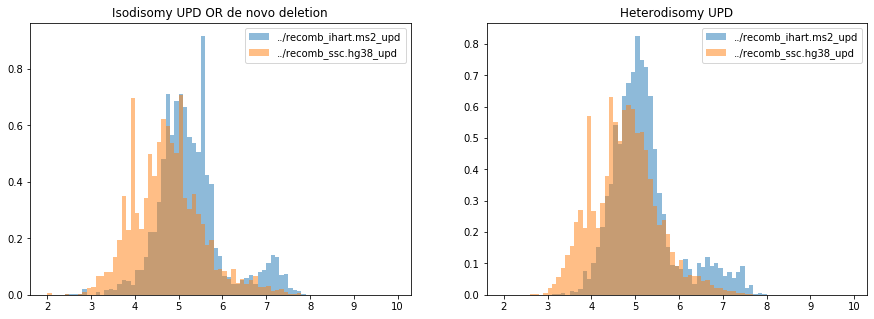

In [966]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(np.log10([upd['end_pos']-upd['start_pos'] for upd in upds if upd['is_isodisomy'] and (upd['chrom']!='X')]), 
         bins=np.arange(2, 10, 0.1), alpha=0.5, density=True, label=dataset_name)
plt.hist(np.log10([upd['end_pos']-upd['start_pos'] for upd in upds2 if upd['is_isodisomy'] and (upd['chrom']!='X')]), 
         bins=np.arange(2, 10, 0.1), alpha=0.5, density=True, label=dataset_name2)
plt.title('Isodisomy UPD OR de novo deletion')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(np.log10([upd['end_pos']-upd['start_pos'] for upd in upds if (not upd['is_isodisomy']) and (upd['chrom']!='X')]), 
         bins=np.arange(2, 10, 0.1), alpha=0.5, density=True, label=dataset_name)
plt.hist(np.log10([upd['end_pos']-upd['start_pos'] for upd in upds2 if (not upd['is_isodisomy']) and (upd['chrom']!='X')]), 
         bins=np.arange(2, 10, 0.1), alpha=0.5, density=True, label=dataset_name2)
plt.title('Heterodisomy UPD')
plt.legend()
#plt.hist(np.log10([upd['end_pos']-upd['start_pos'] for upd in upds2])[np.array([child_id_to_affected[upd['child']]=='2' for upd in upds2])], bins=np.arange(2, 10, 0.5), alpha=0.5, density=True)
#plt.hist(np.log10([upd['end_pos']-upd['start_pos'] for upd in upds2])[~np.array([child_id_to_affected[upd['child']]=='2' for upd in upds2])], bins=np.arange(2, 10, 0.5), alpha=0.5, density=True)
plt.show()


In [973]:
print([upd for upd in upds if (upd['end_pos']-upd['start_pos']>10**7) and (upd['chrom']!='X') and (upd['is_heterodisomy'])])

[{'family': 'AU0625.AU062503.AU062504', 'chrom': '3', 'start_pos': 8717938, 'end_pos': 24437112, 'child': 'AU062504', 'is_mat': True, 'is_pat': False, 'is_isodisomy': False, 'is_heterodisomy': True, 'is_hts': False, 'family_size': 4, 'mom': 'AU062501', 'dad': 'AU062502'}, {'family': 'AU0625.AU062503.AU062504', 'chrom': '3', 'start_pos': 114454248, 'end_pos': 163008202, 'child': 'AU062504', 'is_mat': True, 'is_pat': False, 'is_isodisomy': False, 'is_heterodisomy': True, 'is_hts': False, 'family_size': 4, 'mom': 'AU062501', 'dad': 'AU062502'}, {'family': 'AU0625.AU062503.AU062504', 'chrom': '4', 'start_pos': 71596207, 'end_pos': 88279918, 'child': 'AU062504', 'is_mat': True, 'is_pat': False, 'is_isodisomy': False, 'is_heterodisomy': True, 'is_hts': False, 'family_size': 4, 'mom': 'AU062501', 'dad': 'AU062502'}, {'family': 'AU0625.AU062503.AU062504', 'chrom': '5', 'start_pos': 3914239, 'end_pos': 34395077, 'child': 'AU062504', 'is_mat': True, 'is_pat': False, 'is_isodisomy': False, 'is_he

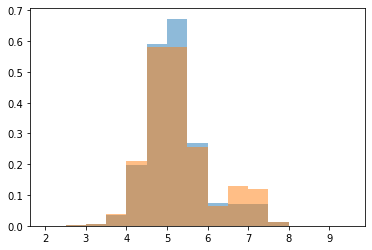

In [942]:
plt.hist(np.log10([upd['end_pos']-upd['start_pos'] for upd in upds])[np.array([child_id_to_affected[upd['child']]=='2' for upd in upds])], bins=np.arange(2, 10, 0.5), alpha=0.5, density=True)
plt.hist(np.log10([upd['end_pos']-upd['start_pos'] for upd in upds])[~np.array([child_id_to_affected[upd['child']]=='2' for upd in upds])], bins=np.arange(2, 10, 0.5), alpha=0.5, density=True)
#plt.hist(np.log10([upd['end_pos']-upd['start_pos'] for upd in upds2])[np.array([child_id_to_affected[upd['child']]=='2' for upd in upds2])], bins=np.arange(2, 10, 0.5), alpha=0.5, density=True)
#plt.hist(np.log10([upd['end_pos']-upd['start_pos'] for upd in upds2])[~np.array([child_id_to_affected[upd['child']]=='2' for upd in upds2])], bins=np.arange(2, 10, 0.5), alpha=0.5, density=True)
plt.show()


In [943]:
with open('%s/deletions.json' % dataset_name, 'r') as f:
    deletions = json.load(f)
    x_deletions = [x for x in deletions if x['chrom'] == 'X' and (not x['is_hts'])]
    deletions = [x for x in deletions if x['chrom'] != 'X' and (not x['is_hts'])]
print(len(deletions), len(x_deletions))

312434 9968


In [944]:
with open('%s/children.json' % dataset_name, 'r') as f:
    children = json.load(f)
    
with open('%s/sibpairs.json' % dataset_name, 'r') as f:
    sibpairs = json.load(f)
    
child_to_families = defaultdict(set)
for sibpair in sibpairs:
    child_to_families[sibpair['sibling1']].add(sibpair['family'])
    child_to_families[sibpair['sibling2']].add(sibpair['family'])
    
print(len(sibpairs))

1969


In [945]:
print(children[:5])

['AU001203', 'AU001204', 'AU002103', 'AU002105', 'AU002106']


In [946]:
child_to_index = dict([(x, i) for i, x in enumerate(children)])

families = []

for child in children:
    fams = child_to_families[child]
    fam = random.choice(list(fams))
    child_to_index[(fam, child)] = child_to_index[child]
    families.append(fam)

is_aut = np.array([child_id_to_affected[child]=='2' for child in children])
is_m = np.array([child_id_to_sex[child]=='1' for child in children])

print(is_aut.shape, is_m.shape)

(2177,) (2177,)


In [947]:
child_to_sib = dict()
for sibpair in sibpairs:
    child_to_sib[(sibpair['family'], sibpair['sibling1'])] = sibpair['sibling2']
    child_to_sib[(sibpair['family'], sibpair['sibling2'])] = sibpair['sibling1']
sib_is_m = np.array([child_id_to_sex[child_to_sib[(fam, child)]]=='1' for fam, child in zip(families, children)])



In [948]:
# child, heterdisomy/isodisomy-de novo deletion/inherited deletion, mat/pat
all_upds = np.zeros((len(children), 3, 2), dtype=int)
all_x_upds = np.zeros((len(children), 3, 2), dtype=int)

for i, upd in enumerate(upds):
    # we flip UPD mat/pat because if we have a maternal UPD, this means the pat copy is missing
    # vs if we have a maternal inherited deletion, this means the mat copy is missing
    if ((upd['family'], upd['child']) in child_to_index):
        all_upds[child_to_index[(upd['family'], upd['child'])], int(upd['is_isodisomy']), int(upd['is_mat'])] += (upd['end_pos']-upd['start_pos'])
    
for upd in x_upds:
    if (upd['family'], upd['child']) in child_to_index:
        all_x_upds[child_to_index[(upd['family'], upd['child'])], int(upd['is_isodisomy']), int(upd['is_mat'])] += (upd['end_pos']-upd['start_pos'])
        
for d in deletions:
    for child in d['trans']:
        if (d['family'], child) in child_to_index:
            all_upds[child_to_index[(d['family'], child)], 2, int(d['is_pat'])] += (d['end_pos']-d['start_pos'])
        
for d in x_deletions:
    for child in d['trans']:
        if (d['family'], child) in child_to_index:
            all_x_upds[child_to_index[(d['family'], child)], 2, int(d['is_pat'])] += (d['end_pos']-d['start_pos'])

print(all_upds.shape)
print(all_x_upds.shape)


(2177, 3, 2)
(2177, 3, 2)


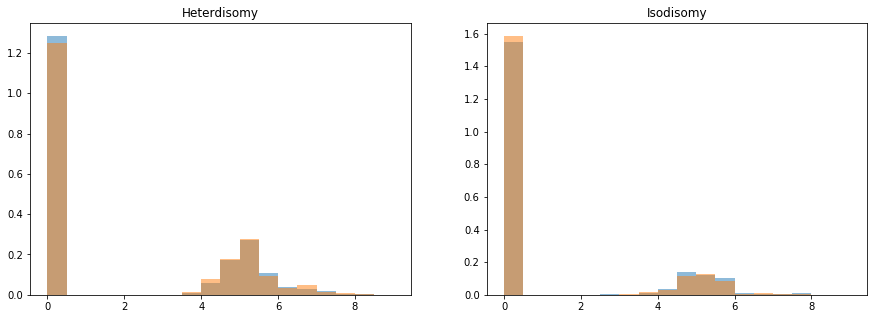

In [949]:
plt.figure(figsize=(15, 5))

bins = np.arange(0, 9.5, 0.5)

plt.subplot(1, 2, 1)
#plt.hist(np.log10(all_upds[is_m, 0, 0]+1), alpha=0.5, bins=bins, density=True)
plt.hist(np.log10(all_upds[is_m, 0, 1]+1), alpha=0.5, bins=bins, density=True)
#plt.hist(np.log10(all_upds[~is_m, 0, 0]+1), alpha=0.5, bins=bins, density=True)
plt.hist(np.log10(all_upds[~is_m, 0, 1]+1), alpha=0.5, bins=bins, density=True)
plt.title('Heterdisomy')

plt.subplot(1, 2, 2)
#plt.hist(np.log10(all_upds[is_m, 1, 0]+1), alpha=0.5, bins=bins, density=True)
plt.hist(np.log10(all_upds[is_m, 1, 1]+1), alpha=0.5, bins=bins, density=True)
#plt.hist(np.log10(all_upds[~is_m, 1, 0]+1), alpha=0.5, bins=bins, density=True)
plt.hist(np.log10(all_upds[~is_m, 1, 1]+1), alpha=0.5, bins=bins, density=True)
plt.title('Isodisomy')
plt.show()

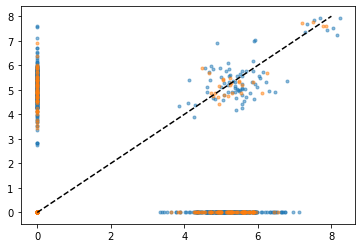

In [955]:
plt.scatter(np.log10(all_upds[is_aut, 1, 0]+1), np.log10(all_upds[is_aut, 1, 1]+1), alpha=0.5, marker='.')
plt.scatter(np.log10(all_upds[~is_aut, 1, 0]+1), np.log10(all_upds[~is_aut, 1, 1]+1), alpha=0.5, marker='.')
#plt.scatter(np.log10(all_upds[:, 1, 0]+1), np.log10(all_upds[:, 1, 1]+1), alpha=0.5, marker='.')
plt.plot([0, 8], [0, 8], color='black', linestyle='--')
plt.show()

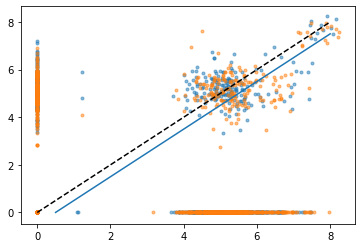

In [950]:
plt.scatter(np.log10(all_upds[:, 0, 0]+1), np.log10(all_upds[:, 1, 0]+1), alpha=0.5, marker='.')
plt.scatter(np.log10(all_upds[:, 0, 1]+1), np.log10(all_upds[:, 1, 1]+1), alpha=0.5, marker='.')
plt.plot([0, 8], [0, 8], color='black', linestyle='--')
plt.plot([0.5, 8], [0, 7.5])
plt.show()

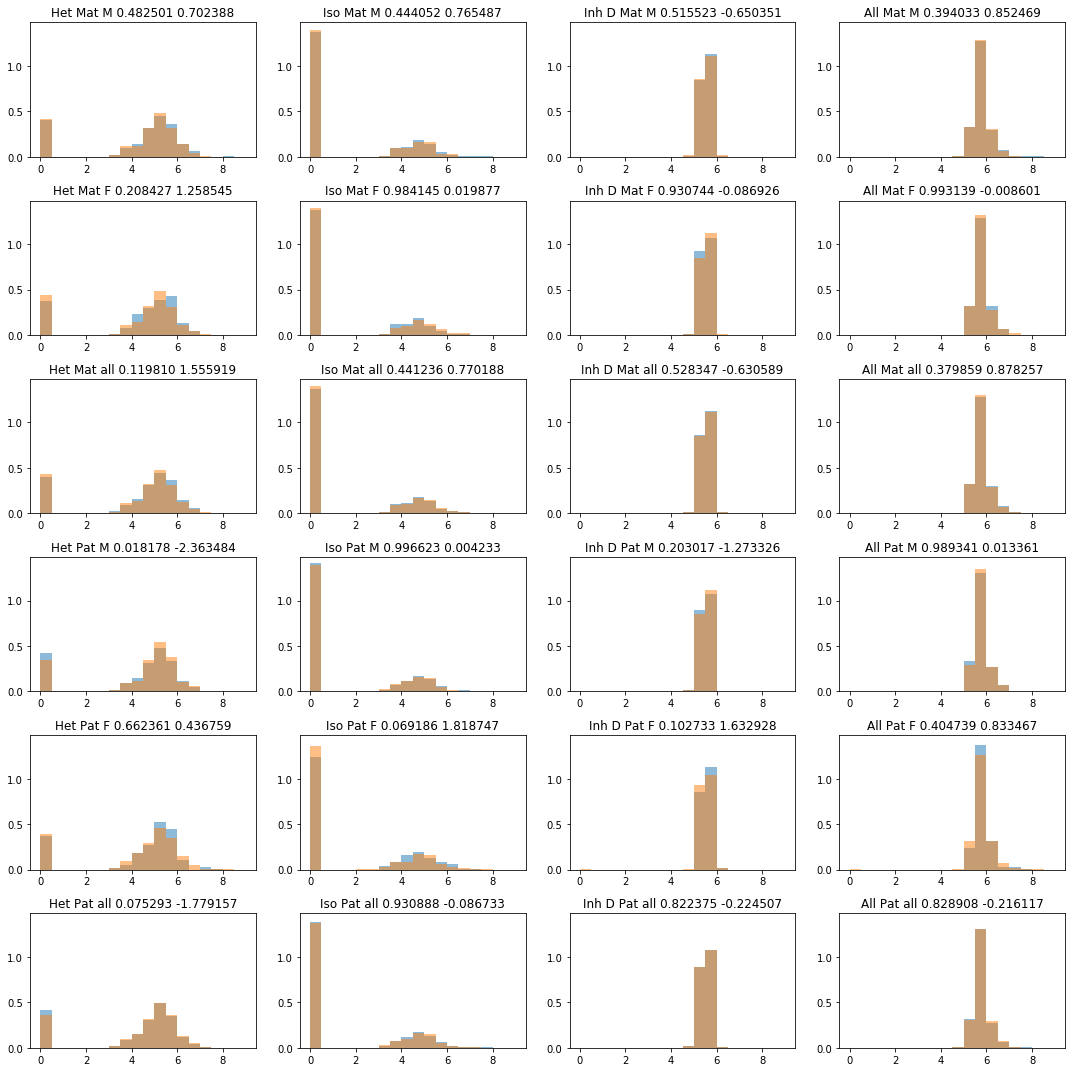

In [916]:
plt.figure(figsize=(15, 15))

ax = plt.subplot(6, 4, 1)
for j in range(2):
    for k, f in enumerate([is_m, ~is_m, (is_m | ~is_m)]):
        for i in range(3):
            plt.subplot(6, 4, (3*j + k)*4 + i + 1, sharey=ax)
            plt.hist(np.log10(all_upds[is_aut & f, i, j]+1), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
            plt.hist(np.log10(all_upds[~is_aut & f, i, j]+1), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
            p = stats.ttest_ind(np.log10(all_upds[is_aut & f, i, j]+1),
                                np.log10(all_upds[~is_aut & f, i, j]+1))
            plt.title('%s %s %s %f %f' % (['Het', 'Iso', 'Inh D'][i], ['Mat', 'Pat'][j], ['M', 'F', 'all'][k], p.pvalue, p.statistic))

        plt.subplot(6, 4, (3*j + k)*4 + 3 + 1, sharey=ax)
        plt.hist(np.log10(np.sum(all_upds[is_aut & f, :, j], axis=1)+1), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
        plt.hist(np.log10(np.sum(all_upds[~is_aut & f, :, j], axis=1)+1), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
        p = stats.ttest_ind(np.log10(np.sum(all_upds[is_aut & f, :, j], axis=1)+1),
                            np.log10(np.sum(all_upds[~is_aut & f, :, j], axis=1)+1))
        plt.title('All %s %s %f %f' % (['Mat', 'Pat'][j], ['M', 'F', 'all'][k], p.pvalue, p.statistic))

        
plt.tight_layout()
plt.show()

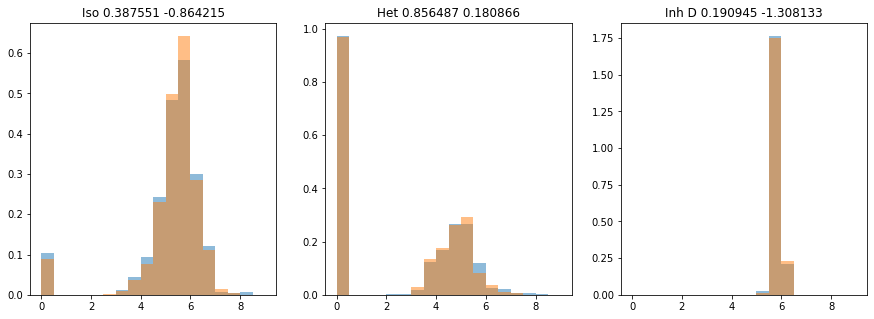

In [905]:
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.hist(np.log10(np.sum(all_upds[is_aut & is_m, i, :], axis=1)+1), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
    plt.hist(np.log10(np.sum(all_upds[~is_aut & is_m, i, :], axis=1)+1), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
    p = stats.ttest_ind(np.log10(np.sum(all_upds[is_aut & is_m, i, :], axis=1)+1),
                        np.log10(np.sum(all_upds[~is_aut & is_m, i, :], axis=1)+1))
    plt.title('%s %f %f' % (['Iso', 'Het', 'Inh D'][i], p.pvalue, p.statistic))


In [906]:
# We conclude that maternal heterodisomy, resulting in the loss of the paternal copy occurs more frequently in 
# autistic children than their neurotpical siblings


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.p

Ttest_indResult(statistic=-0.79414858188777, pvalue=0.4271579856798383)
Ttest_indResult(statistic=0.9142435049197628, pvalue=0.3606462799126843)


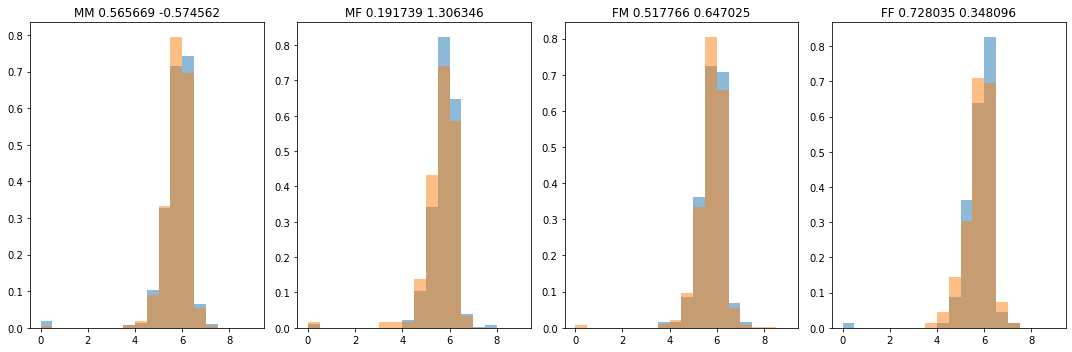

In [609]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.hist(np.clip(np.log10(all_upds[is_aut & is_m & sib_is_m, 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_upds[~is_aut & is_m & sib_is_m, 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_upds[is_aut & is_m & sib_is_m, 1, 1]), 0, 9),
                                np.clip(np.log10(all_upds[~is_aut & is_m & sib_is_m, 1, 1]), 0, 9))
plt.title('MM %f %f' % (p.pvalue, p.statistic))

plt.subplot(1, 4, 2)
plt.hist(np.clip(np.log10(all_upds[is_aut & is_m & ~sib_is_m, 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_upds[~is_aut & is_m & ~sib_is_m, 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_upds[is_aut & is_m & ~sib_is_m, 1, 1]), 0, 9),
                                np.clip(np.log10(all_upds[~is_aut & is_m & ~sib_is_m, 1, 1]), 0, 9))
plt.title('MF %f %f' % (p.pvalue, p.statistic))

plt.subplot(1, 4, 3)
plt.hist(np.clip(np.log10(all_upds[is_aut & ~is_m & sib_is_m, 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_upds[~is_aut & ~is_m & sib_is_m, 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_upds[is_aut & ~is_m & sib_is_m, 1, 1]), 0, 9),
                                np.clip(np.log10(all_upds[~is_aut & ~is_m & sib_is_m, 1, 1]), 0, 9))
plt.title('FM %f %f' % (p.pvalue, p.statistic))

plt.subplot(1, 4, 4)
plt.hist(np.clip(np.log10(all_upds[is_aut & ~is_m & ~sib_is_m, 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_upds[~is_aut & ~is_m & ~sib_is_m, 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_upds[is_aut & ~is_m & ~sib_is_m, 1, 1]), 0, 9),
                                np.clip(np.log10(all_upds[~is_aut & ~is_m & ~sib_is_m, 1, 1]), 0, 9))
plt.title('FF %f %f' % (p.pvalue, p.statistic))

print(stats.ttest_ind(np.clip(np.log10(all_upds[is_m, 1, 1]), 0, 9),
                                np.clip(np.log10(all_upds[~is_m, 1, 1]), 0, 9)))
print(stats.ttest_ind(np.clip(np.log10(all_upds[sib_is_m, 1, 1]), 0, 9),
                                np.clip(np.log10(all_upds[~sib_is_m, 1, 1]), 0, 9)))
      
plt.tight_layout()
plt.show()
    

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10


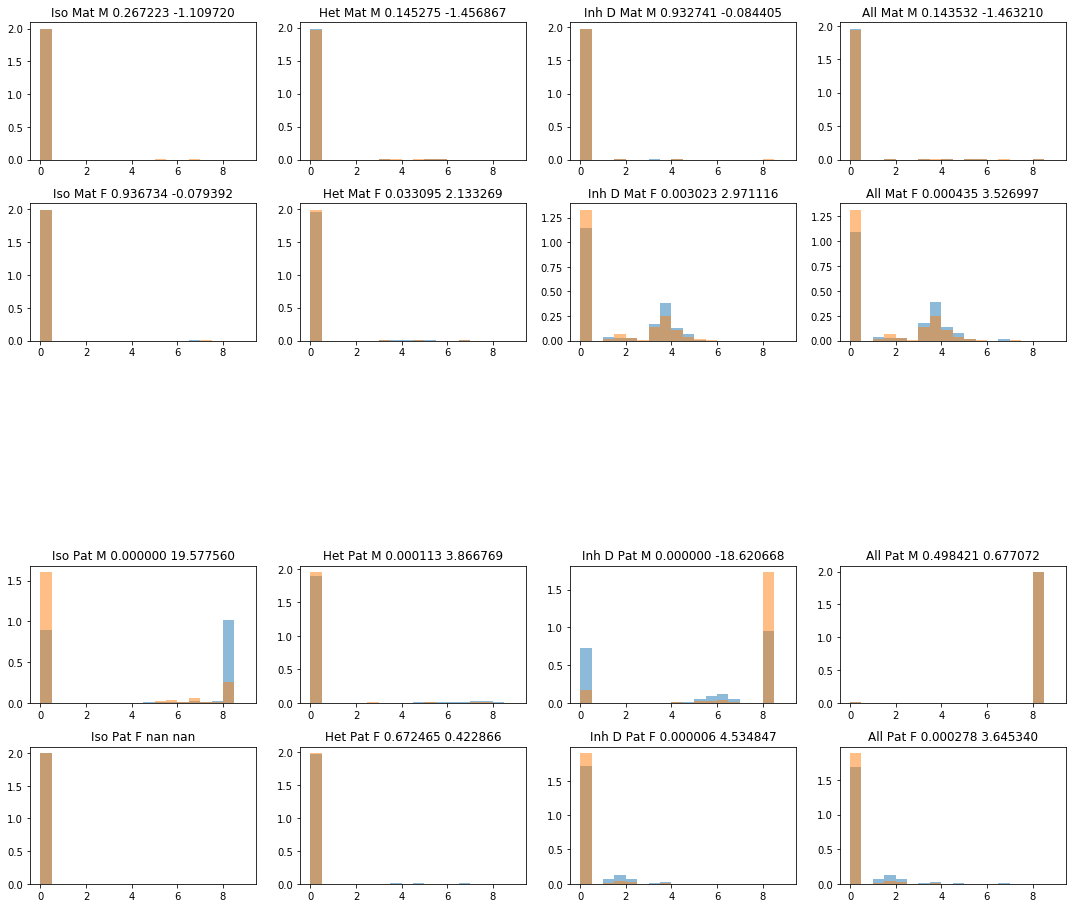

In [610]:
plt.figure(figsize=(15, 15))


for j in range(2):
    for k, f in enumerate([is_m, ~is_m]):
        for i in range(3):
            plt.subplot(6, 4, (3*j + k)*4 + i + 1)
            plt.hist(np.clip(np.log10(all_x_upds[is_aut & f, i, j]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
            plt.hist(np.clip(np.log10(all_x_upds[~is_aut & f, i, j]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
            p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & f, i, j]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & f, i, j]), 0, 9))
            plt.title('%s %s %s %f %f' % (['Iso', 'Het', 'Inh D'][i], ['Mat', 'Pat'][j], ['M', 'F', 'all'][k], p.pvalue, p.statistic))

        plt.subplot(6, 4, (3*j + k)*4 + 3 + 1)
        plt.hist(np.clip(np.log10(np.sum(all_x_upds[is_aut & f, :, j], axis=1)), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
        plt.hist(np.clip(np.log10(np.sum(all_x_upds[~is_aut & f, :, j], axis=1)), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
        p = stats.ttest_ind(np.clip(np.log10(np.sum(all_x_upds[is_aut & f, :, j], axis=1)), 0, 9),
                            np.clip(np.log10(np.sum(all_x_upds[~is_aut & f, :, j], axis=1)), 0, 9))
        plt.title('All %s %s %f %f' % (['Mat', 'Pat'][j], ['M', 'F', 'all'][k], p.pvalue, p.statistic))

        
plt.tight_layout()
plt.show()

In [611]:
# We conclude several things.
# 1. The Y chromosome can be captured by either an inherited deletion (more correct) or maternal isodisomy.
#    For some reason, autistic children tend to have maternal isodisomy rather than an inherited deletion -
#    this could be related to the sex of the neurotypical sibling
# 2. Autistic females inherit more maternal and paternal X deletions than neurotypical females
# 3. Autistic females exhibit more paternal heterodisomy (resulting in loss of maternal copy) than NT females.
# 4. Conversely, autistic males exhibit more maternal heterodisomy (resulting in loss of paternal copy) than NT males.

# 3 and 4 are driven by outliers

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.p

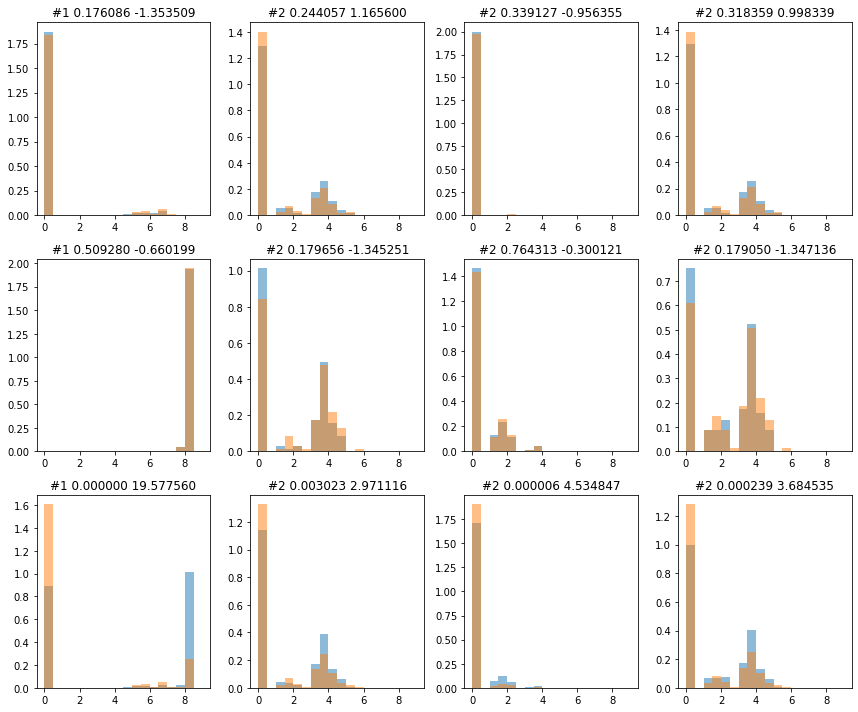

In [612]:
# We break the above conclusions down by sibpair types

# 1
plt.figure(figsize=(15, 10))
plt.subplot(3, 5, 1)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & is_m & sib_is_m, 0, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & is_m & sib_is_m, 0, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & is_m & sib_is_m, 0, 1]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & is_m & sib_is_m, 0, 1]), 0, 9))
plt.title('#1 %f %f' % (p.pvalue, p.statistic))

plt.subplot(3, 5, 6)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & is_m & ~sib_is_m, 0, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & is_m & ~sib_is_m, 0, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & is_m & ~sib_is_m, 0, 1]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & is_m & ~sib_is_m, 0, 1]), 0, 9))
plt.title('#1 %f %f' % (p.pvalue, p.statistic))

plt.subplot(3, 5, 11)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & is_m, 0, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & is_m, 0, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & is_m, 0, 1]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & is_m, 0, 1]), 0, 9))
plt.title('#1 %f %f' % (p.pvalue, p.statistic))

# 2
plt.subplot(3, 5, 2)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & ~is_m & sib_is_m, 2, 0]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & ~is_m & sib_is_m, 2, 0]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & ~is_m & sib_is_m, 2, 0]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & ~is_m & sib_is_m, 2, 0]), 0, 9))
plt.title('#2 %f %f' % (p.pvalue, p.statistic))

plt.subplot(3, 5, 3)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & ~is_m & sib_is_m, 2, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & ~is_m & sib_is_m, 2, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & ~is_m & sib_is_m, 2, 1]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & ~is_m & sib_is_m, 2, 1]), 0, 9))
plt.title('#2 %f %f' % (p.pvalue, p.statistic))

plt.subplot(3, 5, 4)
plt.hist(np.clip(np.log10(np.sum(all_x_upds[is_aut & ~is_m & sib_is_m, 2, :], axis=1)), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(np.sum(all_x_upds[~is_aut & ~is_m & sib_is_m, 2, :], axis=1)), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(np.sum(all_x_upds[is_aut & ~is_m & sib_is_m, 2, :], axis=1)), 0, 9),
                                np.clip(np.log10(np.sum(all_x_upds[~is_aut & ~is_m & sib_is_m, 2, :], axis=1)), 0, 9))
plt.title('#2 %f %f' % (p.pvalue, p.statistic))

plt.subplot(3, 5, 7)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & ~is_m & ~sib_is_m, 2, 0]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & ~is_m & ~sib_is_m, 2, 0]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & ~is_m & ~sib_is_m, 2, 0]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & ~is_m & ~sib_is_m, 2, 0]), 0, 9))
plt.title('#2 %f %f' % (p.pvalue, p.statistic))

plt.subplot(3, 5, 8)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & ~is_m & ~sib_is_m, 2, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & ~is_m & ~sib_is_m, 2, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & ~is_m & ~sib_is_m, 2, 1]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & ~is_m & ~sib_is_m, 2, 1]), 0, 9))
plt.title('#2 %f %f' % (p.pvalue, p.statistic))

plt.subplot(3, 5, 9)
plt.hist(np.clip(np.log10(np.sum(all_x_upds[is_aut & ~is_m & ~sib_is_m, 2, :], axis=1)), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(np.sum(all_x_upds[~is_aut & ~is_m & ~sib_is_m, 2, :], axis=1)), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(np.sum(all_x_upds[is_aut & ~is_m & ~sib_is_m, 2, :], axis=1)), 0, 9),
                                np.clip(np.log10(np.sum(all_x_upds[~is_aut & ~is_m & ~sib_is_m, 2, :], axis=1)), 0, 9))
plt.title('#2 %f %f' % (p.pvalue, p.statistic))

plt.subplot(3, 5, 12)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & ~is_m, 2, 0]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & ~is_m, 2, 0]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & ~is_m, 2, 0]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & ~is_m, 2, 0]), 0, 9))
plt.title('#2 %f %f' % (p.pvalue, p.statistic))

plt.subplot(3, 5, 13)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & ~is_m, 2, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & ~is_m, 2, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & ~is_m, 2, 1]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & ~is_m, 2, 1]), 0, 9))
plt.title('#2 %f %f' % (p.pvalue, p.statistic))

plt.subplot(3, 5, 14)
plt.hist(np.clip(np.log10(np.sum(all_x_upds[is_aut & ~is_m, 2, :], axis=1)), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(np.sum(all_x_upds[~is_aut & ~is_m, 2, :], axis=1)), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(np.sum(all_x_upds[is_aut & ~is_m, 2, :], axis=1)), 0, 9),
                                np.clip(np.log10(np.sum(all_x_upds[~is_aut & ~is_m, 2, :], axis=1)), 0, 9))
plt.title('#2 %f %f' % (p.pvalue, p.statistic))

plt.tight_layout()
plt.show()


In [613]:
# We conclude that #1 is incorrect - male children with female siblings tend to go the maternal isodisomy route
# We conclude that #2 is incorect - we are more likely to find inherited deletions in female children with sisters 
# than in female children with brothers. In turn, female children with sisters are more likely to be autistic
# than female children with brothers in our dataset

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.p

Ttest_indResult(statistic=-3.7205976118211512, pvalue=0.0002074669932007787)
Ttest_indResult(statistic=-10.461101919451904, pvalue=4.122307881485765e-25)


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:50: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: divide by zero encountered in log10


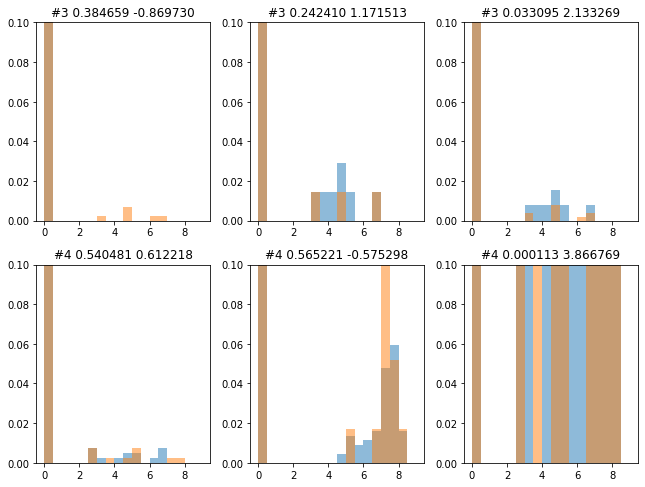

In [614]:
# We break the above conclusions down by sibpair types

# 3
plt.figure(figsize=(15, 10))
ax = plt.subplot(3, 5, 1)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & ~is_m & sib_is_m, 1, 0]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & ~is_m & sib_is_m, 1, 0]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & ~is_m & sib_is_m, 1, 0]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & ~is_m & sib_is_m, 1, 0]), 0, 9))
plt.title('#3 %f %f' % (p.pvalue, p.statistic))
plt.ylim([None, 0.1])

plt.subplot(3, 5, 2, sharey=ax)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & ~is_m & ~sib_is_m, 1, 0]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & ~is_m & ~sib_is_m, 1, 0]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & ~is_m & ~sib_is_m, 1, 0]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & ~is_m & ~sib_is_m, 1, 0]), 0, 9))
plt.title('#3 %f %f' % (p.pvalue, p.statistic))
plt.ylim([None, 0.1])

plt.subplot(3, 5, 3, sharey=ax)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & ~is_m, 1, 0]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & ~is_m , 1, 0]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & ~is_m , 1, 0]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & ~is_m , 1, 0]), 0, 9))
plt.title('#3 %f %f' % (p.pvalue, p.statistic))
plt.ylim([None, 0.1])

print(stats.ttest_ind(np.clip(np.log10(all_x_upds[sib_is_m & ~is_m , 1, 0]), 0, 9),
                                np.clip(np.log10(all_x_upds[~sib_is_m & ~is_m , 1, 0]), 0, 9)))

ax = plt.subplot(3, 5, 6)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & is_m & sib_is_m, 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & is_m & sib_is_m, 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & is_m & sib_is_m, 1, 1]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & is_m & sib_is_m, 1, 1]), 0, 9))
plt.title('#4 %f %f' % (p.pvalue, p.statistic))
plt.ylim([None, 0.1])

plt.subplot(3, 5, 7, sharey=ax)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & is_m & ~sib_is_m, 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & is_m & ~sib_is_m, 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5), density=True)
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & is_m & ~sib_is_m, 1, 1]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & is_m & ~sib_is_m, 1, 1]), 0, 9))
plt.title('#4 %f %f' % (p.pvalue, p.statistic))
plt.ylim([None, 0.1])

plt.subplot(3, 5, 8, sharey=ax)
plt.hist(np.clip(np.log10(all_x_upds[is_aut & is_m , 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5))
plt.hist(np.clip(np.log10(all_x_upds[~is_aut & is_m , 1, 1]), 0, 9), alpha=0.5, bins=np.arange(0, 9.5, 0.5))
p = stats.ttest_ind(np.clip(np.log10(all_x_upds[is_aut & is_m , 1, 1]), 0, 9),
                                np.clip(np.log10(all_x_upds[~is_aut & is_m , 1, 1]), 0, 9))
plt.title('#4 %f %f' % (p.pvalue, p.statistic))
plt.ylim([None, 0.1])
      
print(stats.ttest_ind(np.clip(np.log10(all_x_upds[sib_is_m & is_m , 1, 1]), 0, 9),
                                np.clip(np.log10(all_x_upds[~sib_is_m & is_m , 1, 1]), 0, 9)))

plt.tight_layout()
plt.show()


In [615]:
# We conclude that 3 and 4 are false as well - both males and females with female siblings are more likely to have
# heterodisomy

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


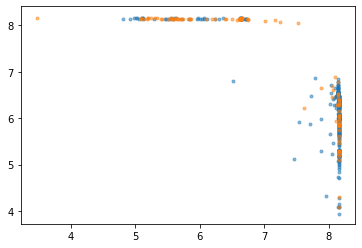

In [616]:
plt.scatter(np.log10(all_x_upds[is_m & is_aut, 0, 1]), np.log10(all_x_upds[is_m & is_aut, 2, 1]), marker='.', alpha=0.5)
plt.scatter(np.log10(all_x_upds[is_m & ~is_aut, 0, 1]), np.log10(all_x_upds[is_m & ~is_aut, 2, 1]), marker='.', alpha=0.5)

plt.show()
